## Human Activity Recognition from accelerometer data

Note: Settling to use Deep Neural Net architecture

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [70]:
datafolder='Activity_Recognition_from Single_Chest-Mounted_Accelerometer/'
person={}
for i in range(15):
    person[i+1]= pd.read_csv(datafolder+str(i+1)+'.csv',index_col=0,names=['seq num', 'ax', 'ay', 'az', 'label']) 

In [71]:
for i in person: print(i,'shape:',person[i].shape)#,'columns:',person[i].columns)

1 shape: (162501, 4)
2 shape: (138001, 4)
3 shape: (102341, 4)
4 shape: (122201, 4)
5 shape: (160001, 4)
6 shape: (140901, 4)
7 shape: (163001, 4)
8 shape: (138001, 4)
9 shape: (166741, 4)
10 shape: (126801, 4)
11 shape: (104451, 4)
12 shape: (114702, 4)
13 shape: (67651, 4)
14 shape: (116101, 4)
15 shape: (103501, 4)


In [72]:
class_dict={}
class_dict[1]='Working at Computer'
class_dict[2]='Standing Up, Walking and Going Up/Down stairs' 
class_dict[3]='Standing'
class_dict[4]='Walking'
class_dict[5]='Going Up/Down Stairs'
class_dict[6]='Walking and Talking with Someone'
class_dict[7]='Talking while Standing'

In [73]:
#person[1].head()

In [74]:
#after 100000 the time step does not increment by 1?
#person[1].iloc[99997:100003]

In [76]:
def plot_data(folder='raw',save=False):
    os.system('mkdir -p plots/'+folder)
    for i in person:

        fig, ax = plt.subplots(4,1, figsize=(6.4*1.5,4.8*1.5),sharex='col') 

        ax[0].plot(person[i]['ax'])
        ax[0].set_ylabel('ax')

        ax[1].plot(person[i]['ay'])
        ax[1].set_ylabel('ay')

        ax[2].plot(person[i]['az'])
        ax[2].set_ylabel('az')

        ax[3].plot(person[i]['label'])
        ax[3].set_ylabel('label')

        fig.suptitle('person '+str(i))

        if(save):fig.savefig('plots/'+folder+'/'+'person'+str(i))
        
        
def normalize_data(dataset):
    dataset = dataset - dataset.mean()
    dataset = dataset/dataset.std()
    return dataset


def get_data_per_class_per_person():
    #separate data into classes 
    #act := act[class type][person number]
    act = {}
    for i in range(1,8):
        act[i] = {}
        for j in person:
            act[i][j] = person[j][person[j]['label']==i]

    return act


def plot_per_class_per_person(act,save=False):
    folder = 'separate_class'
    os.system('mkdir -pv plots/'+folder)
    for c in range(1,8):

        for i in person:

            fig, ax = plt.subplots(3,1, figsize=(6.4*2,4.8*1.5),sharex='col') 

            ax[0].plot(act[c][i]['ax'],'.')
            ax[0].set_ylabel('ax')

            ax[1].plot(act[c][i]['ay'],'.')
            ax[1].set_ylabel('ay')

            ax[2].plot(act[c][i]['az'],'.')
            ax[2].set_ylabel('az')

            fig.suptitle('person '+str(i)+': '+class_dict[c])

            if(save):fig.savefig('plots/'+folder+'/'+'act_'+str(c)+'_person '+str(i))

            if i > 3:
                fig.clf()


# Remove entries with label=0
def remove_0_labels():
    for i in person:
        index_to_drop = person[i][person[i]['label']==0].index
        person[i] = person[i].drop(index_to_drop)

        
# normalize data
def normalize_all_data():
    for i in person: 
        for col in ['ax','ay','az']:
            person[i][col] = normalize_data(person[i][col])

In [77]:
###FEATURE ENGINEERING

def add_features(window=52 * 3):

    print('using window of',window)

    #Add rolling mean
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_MA'+str(window)] = person[i][col].rolling(window).mean()

    #Add rolling std
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_stdA'+str(window)] = person[i][col].rolling(window).std()

    #Add rolling sum
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_sumA'+str(window)] = person[i][col].rolling(window).sum()

    #Add rolling max
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_maxA'+str(window)] = person[i][col].rolling(window).max()

    #Add rolling min
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_minA'+str(window)] = person[i][col].rolling(window).min()

    #Add rolling median
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_medA'+str(window)] = person[i][col].rolling(window).median()

    #Add rolling covariance
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_covA'+str(window)] = person[i][col].rolling(window).cov()

    #Add rolling kurtosis
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_kurtA'+str(window)] = person[i][col].rolling(window).kurt()

    #Add rolling skew
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_skewA'+str(window)] = person[i][col].rolling(window).skew()    

    #Add magnitude of total acc vector sqrt(ax^2+ay^2+az^2)
    for i in person:
        person[i]['mag_a'] = np.sqrt (person[i]['ax']**2 + person[i]['ay']**2 + person[i]['az']**2)

    #Add rolling mean of magnitude of total acc 
    for i in person:
        person[i]['mag_a_MA'] = person[i]['mag_a'].rolling(window).mean()

    #Add rolling sum of magnitude of total acc 
    for i in person:
        person[i]['mag_a_MA'] = person[i]['mag_a'].rolling(window).sum()

    #Add rolling std of magnitude of total acc 
    for i in person:
        person[i]['mag_a_MA'] = person[i]['mag_a'].rolling(window).std()

    #Add angle
    for i in person:
        for col in ['ax','ay','az']:
            person[i]['phi_'+col] = np.arccos( person[i][col] / person[i]['mag_a'] )   

    #Add difference between time steps 
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_diff'] = person[i][col].diff()

    #Add rolling mean of difference between time steps 
    for i in person:
        for col in ['ax','ay','az']:
            person[i][col+'_diff_MA'] = person[i][col+'_diff'].rolling(window).mean()



In [78]:
# preprocess dataset for Time series Neural Net architecture
# WINDOW = 3 sec = 52 * 3 rows
# OVERLAP = 50%

def get_loop_param(dataset):
    window=52*3
    overlap=0.5
    length=dataset.shape[0]
    stride=int(window*overlap)
    num_loop=int(length / stride)
    skip= int(length % stride)
    print('len =',length,'num_loop =',num_loop,'window =',window,'stride =',stride,'skip =',skip,'check =', num_loop*stride + skip)
    
    return num_loop,window,stride,skip

def preprocess_into_3d_np(dataset):

    num_loop,window,stride,skip = get_loop_param(dataset)

    X = np.empty([num_loop,window,dataset.shape[1]-1])
    Y = np.empty([num_loop,1])
    
    datasetX = dataset.drop(columns=['label'])
    datasetY = dataset['label']

    for i in range(num_loop):
        for j in range(window):

            window_iloc = i*stride + j 
            if (i%250==0 and j==0): print(i,j,window_iloc)
            try:
                X[i][j] = datasetX.iloc[window_iloc].values
            except Exception as e:
                print('finished, or error occured:',e)
                break

        # get most frequent value of label in the window
        Y[i] = datasetY.iloc[i*stride : i*stride + window].value_counts().idxmax() 

    return X,Y

In [79]:
def save_preprocess_3d_np(person,save_folder):

    X_person={}
    Y_person={}

    os.system('mkdir -vp '+save_folder)
    for p in person:
        print('\nPerson',p,'\n')
        X_person[p],Y_person[p] = preprocess_into_3d_np(person[p])
        np.save(save_folder+'/X_person_{}'.format(p),X_person[p])
        np.save(save_folder+'/Y_person_{}'.format(p),Y_person[p])  

def get_preprocess_3d_np(save_folder):
    X_person={}
    Y_person={}

    print("\nLoad from folder:",save_folder,'\n')
    for p in person:
        X_person[p]=np.load(save_folder+'/X_person_{}.npy'.format(p))
        Y_person[p]=np.load(save_folder+'/Y_person_{}.npy'.format(p))  
        print('\tLoading Person',p,':',X_person[p].shape,Y_person[p].shape,'\n')

    return X_person,Y_person

In [80]:
#clean up NaN
def fillna_with_zeros():
    for p in person:
        person[p].fillna(0)

In [81]:
#probably need some filtering
def lowpassfilter(dataset):
    pass

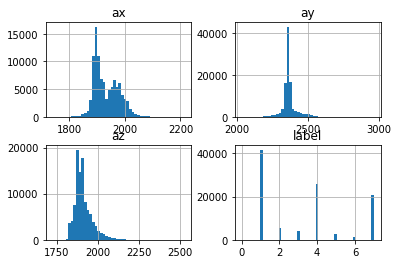

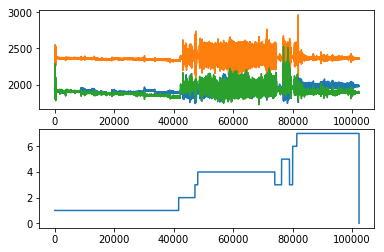

In [82]:
# plot_data('raw')
fig,ax = person[3].hist(bins=50)
fig2,ax2 = plt.subplots(2,1)
ax2[0].plot(person[3].drop(columns='label'))
ax2[1].plot(person[3]['label'])

In [75]:
#there are entries with invalid class=0
#person[2][person[2]['label']==0].head()
remove_0_labels()
normalize_all_data()

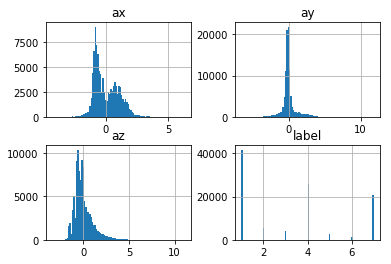

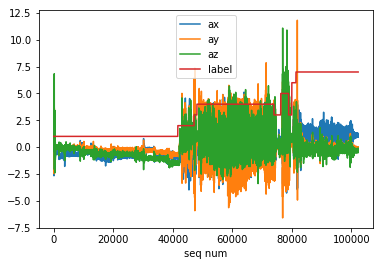

In [84]:
# plot_data('normalized')
person[3].hist(bins=100)
person[3].plot()

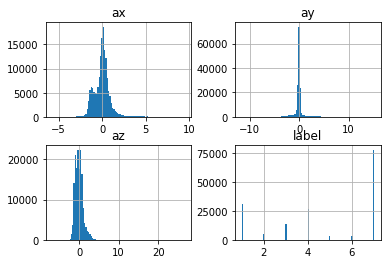

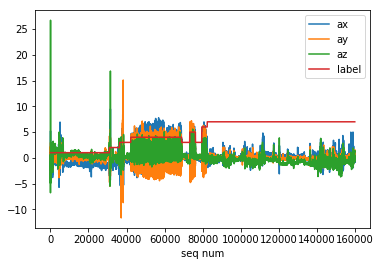

In [160]:
person[5].hist(bins=100)
person[5].plot()

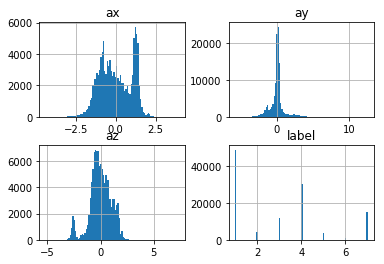

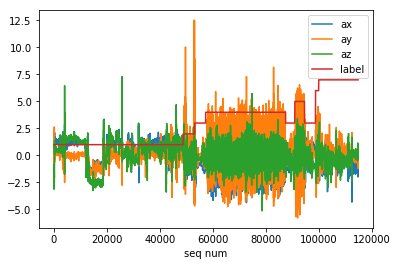

In [161]:
person[12].hist(bins=100)
person[12].plot()

ax and az consistently have a larger spread compared to ay. ay is likely be the vertical axis.

In [178]:
# act = get_data_per_class_per_person()
# plot_per_class_per_person(act)

In [179]:
person[3].head()

,ax,ay,az,label
seq num,,,,
0.0,-0.100870,0.314815,0.566221,1
1.0,-0.279598,0.176180,0.584243,1
2.0,-0.301938,0.156375,0.548200,1
3.0,-0.212575,0.314815,0.674352,1
4.0,-0.257257,0.156375,0.674352,1


In [180]:
# save_preprocess_3d_np(person,'data_norm_3d_np')
# add_features()
# fillna_with_zeros() 
# save_preprocess_3d_np(person,'data_norm_3d_np_withFeatures')

In [181]:
X_person, Y_person = get_preprocess_3d_np('data_norm_3d_np')
X_ext_person, Y_ext_person = get_preprocess_3d_np('data_norm_3d_np_withFeatures')


Load from folder: data_norm_3d_np 

	Loading Person 1 : (2083, 156, 3) (2083, 1) 

	Loading Person 2 : (1765, 156, 3) (1765, 1) 

	Loading Person 3 : (1311, 156, 3) (1311, 1) 

	Loading Person 4 : (1566, 156, 3) (1566, 1) 

	Loading Person 5 : (2051, 156, 3) (2051, 1) 

	Loading Person 6 : (1803, 156, 3) (1803, 1) 

	Loading Person 7 : (2089, 156, 3) (2089, 1) 

	Loading Person 8 : (1766, 156, 3) (1766, 1) 

	Loading Person 9 : (2099, 156, 3) (2099, 1) 

	Loading Person 10 : (1625, 156, 3) (1625, 1) 

	Loading Person 11 : (1339, 156, 3) (1339, 1) 

	Loading Person 12 : (1470, 156, 3) (1470, 1) 

	Loading Person 13 : (867, 156, 3) (867, 1) 

	Loading Person 14 : (1488, 156, 3) (1488, 1) 

	Loading Person 15 : (1326, 156, 3) (1326, 1) 


Load from folder: data_norm_3d_np_withFeatures 

	Loading Person 1 : (2083, 156, 41) (2083, 1) 

	Loading Person 2 : (1765, 156, 41) (1765, 1) 

	Loading Person 3 : (1311, 156, 41) (1311, 1) 

	Loading Person 4 : (1566, 156, 41) (1566, 1) 

	Loading Per

In [89]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping

#required to remove a weird error:
#OMP: Error #15: Initializing libiomp5.dylib, but found libomp.dylib already initialized.
#http://support.genarts.com/knowledgebase/article/View/1365/339/why-am-i-getting-this-error-omp-error-15-initializing-libiomp5so-but-found-libguideso-already-initialized
#https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [90]:
# X_person = X_ext_person
# Y_person = Y_ext_person

#train test "split"
trainX = X_person[1]
trainy = Y_person[1]
for i in [2,3,4,5,6,7,8,9,10]:
    trainX = np.concatenate((trainX,X_person[i]))
    trainy =np.concatenate((trainy,Y_person[i]))
print(trainX.shape,trainy.shape)

valX = X_person[11]
valX = np.concatenate((valX,X_person[12]))
valy = Y_person[11]
valy = np.concatenate((valy,Y_person[12]))
print(valX.shape,valy.shape)

#train test "split"
testX = X_person[13]
testy = Y_person[13]
for i in [14,15]:
    testX = np.concatenate((testX,X_person[i]))
    testy =np.concatenate((testy,Y_person[i]))
print(testX.shape,testy.shape)


# zero-offset class values
trainy = trainy - 1
valy = valy - 1
testy = testy - 1

# one hot encode y
trainy = to_categorical(trainy,dtype='int')
valy = to_categorical(valy,dtype='int')
testy = to_categorical(testy,dtype='int')


(18158, 156, 3) (18158, 1)
(2809, 156, 3) (2809, 1)
(3681, 156, 3) (3681, 1)


In [98]:

def get_MODEL_CNN(model,n_timesteps, n_features):

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))

    return model

def get_MODEL_LSTM(model,n_timesteps, n_features): 
    
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))

    return model

def get_MODEL_CNN_GRU(model,n_timesteps, n_features):

    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GRU(50))
    model.add(Dense(100, activation='relu'))

    return model

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, arch='CNN'):
    verbose, epochs, batch_size = 1, 10, 32
    #verbose, epochs, batch_size = 1, 15, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    model = Sequential()

    if(arch=='CNN'):model = get_MODEL_CNN(model, n_timesteps, n_features)
    elif(arch=='LSTM'):model = get_MODEL_LSTM(model,n_timesteps, n_features)
    elif(arch=='CNN_GRU'):model = get_MODEL_CNN_GRU(model,n_timesteps, n_features)

    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

    # fit network
    history = model.fit(trainX, 
                        trainy, 
                        validation_data=(testX,testy),
                        #validation_split=0.2
                        epochs=epochs, 
                        batch_size=batch_size, 
                        verbose=verbose,
                        callbacks=[early_stop],
                       )
    
    # evaluate model
    _, accuracy = model.evaluate(testX, 
                                 testy, 
                                 batch_size=batch_size, 
                                 verbose=1)

    return history,accuracy,model

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


In [99]:
history_cnn,score_cnn,model_cnn = evaluate_model(trainX, trainy, valX, valy,'CNN')

Train on 18158 samples, validate on 2809 samples
Epoch 1/10
18158/18158 [==============================] - 17s 957us/step - loss: 0.8566 - acc: 0.7297 - val_loss: 1.8488 - val_acc: 0.4721
Epoch 2/10
18158/18158 [==============================] - 16s 903us/step - loss: 0.6416 - acc: 0.7902 - val_loss: 1.8152 - val_acc: 0.4895
Epoch 3/10
18158/18158 [==============================] - 16s 883us/step - loss: 0.5409 - acc: 0.8176 - val_loss: 2.1505 - val_acc: 0.4728
Epoch 4/10
18158/18158 [==============================] - 15s 850us/step - loss: 0.4696 - acc: 0.8402 - val_loss: 1.9657 - val_acc: 0.4692
Epoch 00004: early stopping
2809/2809 [==============================] - 1s 195us/step


In [100]:
history_lstm,score_lstm,model_lstm = evaluate_model(trainX, trainy, valX, valy,'LSTM')

Train on 18158 samples, validate on 2809 samples
Epoch 1/10
18158/18158 [==============================] - 184s 10ms/step - loss: 1.1681 - acc: 0.6047 - val_loss: 1.6042 - val_acc: 0.5226
Epoch 2/10
18158/18158 [==============================] - 175s 10ms/step - loss: 1.0301 - acc: 0.6643 - val_loss: 1.4325 - val_acc: 0.5002
Epoch 3/10
18158/18158 [==============================] - 176s 10ms/step - loss: 0.9802 - acc: 0.6761 - val_loss: 1.8789 - val_acc: 0.4891
Epoch 4/10
18158/18158 [==============================] - 175s 10ms/step - loss: 0.9487 - acc: 0.6972 - val_loss: 1.3525 - val_acc: 0.4439
Epoch 5/10
18158/18158 [==============================] - 178s 10ms/step - loss: 1.0147 - acc: 0.6606 - val_loss: 1.9472 - val_acc: 0.4710
Epoch 6/10
18158/18158 [==============================] - 177s 10ms/step - loss: 0.9907 - acc: 0.6741 - val_loss: 1.3555 - val_acc: 0.4738
Epoch 00006: early stopping
2809/2809 [==============================] - 7s 2ms/step


In [101]:
history_cnn_gru,score_cnn_gru,model_cnn_gru = evaluate_model(trainX, trainy, valX, valy,'CNN_GRU')

Train on 18158 samples, validate on 2809 samples
Epoch 1/10
18158/18158 [==============================] - 89s 5ms/step - loss: 0.9107 - acc: 0.7060 - val_loss: 2.0116 - val_acc: 0.4660
Epoch 2/10
18158/18158 [==============================] - 87s 5ms/step - loss: 0.6771 - acc: 0.7826 - val_loss: 2.0522 - val_acc: 0.4550
Epoch 3/10
18158/18158 [==============================] - 88s 5ms/step - loss: 0.6122 - acc: 0.8032 - val_loss: 2.0328 - val_acc: 0.4838
Epoch 00003: early stopping
2809/2809 [==============================] - 3s 1ms/step


CNN Model is much faster with similar results. Will stick with 1D CNN model

In [102]:
#CNN - predictions

y_train_pred_cnn = model_cnn.predict(trainX)
y_val_pred_cnn = model_cnn.predict(valX)
y_test_pred_cnn = model_cnn.predict(testX)
print('CNN model score:',score_cnn)

y_train_pred_cnn_argmax = np.argmax(y_train_pred_cnn, axis=1)+1 #recover off set
y_val_pred_cnn_argmax = np.argmax(y_val_pred_cnn, axis=1)+1 #recover off set
y_test_pred_cnn_argmax = np.argmax(y_test_pred_cnn, axis=1)+1 #recover off set

print(y_train_pred_cnn_argmax.shape)
print(y_val_pred_cnn_argmax.shape)
print(y_test_pred_cnn_argmax.shape)


CNN model score: 0.4692061231595929
(18158,)
(2809,)
(3681,)


In [260]:
#CONFUSION MATRIX

from sklearn.metrics import confusion_matrix
import seaborn as sns

def draw_conf_mat(cnf_matrix):
    class_names = [class_dict[i] for i in range(1,8)]

    ax = sns.heatmap(cnf_matrix,annot=True,fmt="d")
    ax.figure.set_size_inches(11,8)
    ax.set_xticklabels(class_names,rotation='vertical')
    ax.set_yticklabels(class_names,rotation='horizontal')

def get_conf_matr(ytrue,ypred):
    crosstab = pd.crosstab(ytrue, ypred,
                              rownames=['True'], colnames=['Predicted'],
                              margins=True)
    return crosstab


def get_analytics(conf_mat):

    precision={}
    recall={}
    F1score={}

    print('\nPrecision :\n')
    for p in range(1,8): 
        precision[p] = conf_mat.loc[p,p] / conf_mat.loc['All',p] 
        print('\t',p,': %.2f'%precision[p],'\t',class_dict[p])

    print('\nRecall :\n')
    for p in range(1,8): 
        recall[p] = conf_mat.loc[p,p] / conf_mat.loc[p,'All']
        print('\t',p,': %.2f'%recall[p],'\t',class_dict[p])

    print('\nF1 score :\n')
    for p in range(1,8): 
        F1score[p] = 2 * (precision[p] * recall[p]) / (precision[p] + recall[p])
        if(np.isnan(F1score[p])):F1score[p]=0
        print('\t',p,': %.2f'%F1score[p],'\t',class_dict[p])

    tp_tot = 0
    for p in range(1,8): 
        tp_tot = tp_tot + conf_mat.loc[p,p] 
    acc = tp_tot / conf_mat.loc['All','All']
    
    print('\nAccuracy :\t%.2f'%acc)

In [261]:
#take highest probability as prediction and recover offset
y_train = np.argmax(trainy,axis=1)+1
y_val = np.argmax(valy,axis=1)+1
y_test = np.argmax(testy,axis=1)+1    

Train set

Precision :

	 1 : 0.93 	 Working at Computer
	 2 : 0.80 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.67 	 Standing
	 4 : 0.92 	 Walking
	 5 : 0.74 	 Going Up/Down Stairs
	 6 : 0.60 	 Walking and Talking with Someone
	 7 : 0.89 	 Talking while Standing

Recall :

	 1 : 0.95 	 Working at Computer
	 2 : 0.27 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.73 	 Standing
	 4 : 0.93 	 Walking
	 5 : 0.44 	 Going Up/Down Stairs
	 6 : 0.32 	 Walking and Talking with Someone
	 7 : 0.94 	 Talking while Standing

F1 score :

	 1 : 0.94 	 Working at Computer
	 2 : 0.40 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.70 	 Standing
	 4 : 0.92 	 Walking
	 5 : 0.55 	 Going Up/Down Stairs
	 6 : 0.41 	 Walking and Talking with Someone
	 7 : 0.92 	 Talking while Standing

Accuracy :	0.87


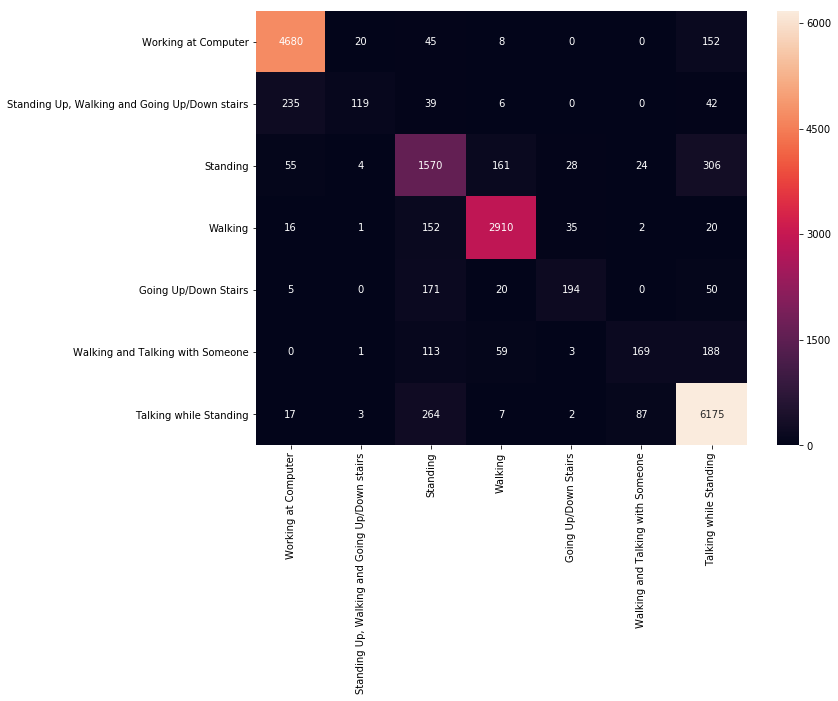

In [262]:
print("Train set")#. Model Accuracy:",history_cnn.history['acc'][-1])
conf_mat = get_conf_matr(y_train,y_train_pred_cnn_argmax)
cnf_matrix_train = confusion_matrix(y_train, y_train_pred_cnn_argmax)
draw_conf_mat(cnf_matrix_train)
get_analytics(conf_mat)

Validation set

Precision :

	 1 : 0.83 	 Working at Computer
	 2 : 0.07 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.14 	 Standing
	 4 : 0.81 	 Walking
	 5 : 0.32 	 Going Up/Down Stairs
	 6 : 0.00 	 Walking and Talking with Someone
	 7 : 0.24 	 Talking while Standing

Recall :

	 1 : 0.33 	 Working at Computer
	 2 : 0.01 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.18 	 Standing
	 4 : 0.87 	 Walking
	 5 : 0.14 	 Going Up/Down Stairs
	 6 : 0.00 	 Walking and Talking with Someone
	 7 : 0.70 	 Talking while Standing

F1 score :

	 1 : 0.47 	 Working at Computer
	 2 : 0.02 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.15 	 Standing
	 4 : 0.84 	 Walking
	 5 : 0.19 	 Going Up/Down Stairs
	 6 : 0.00 	 Walking and Talking with Someone
	 7 : 0.35 	 Talking while Standing

Accuracy :	0.47


/anaconda2/envs/activity_recognition/lib/python3.6/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in double_scalars


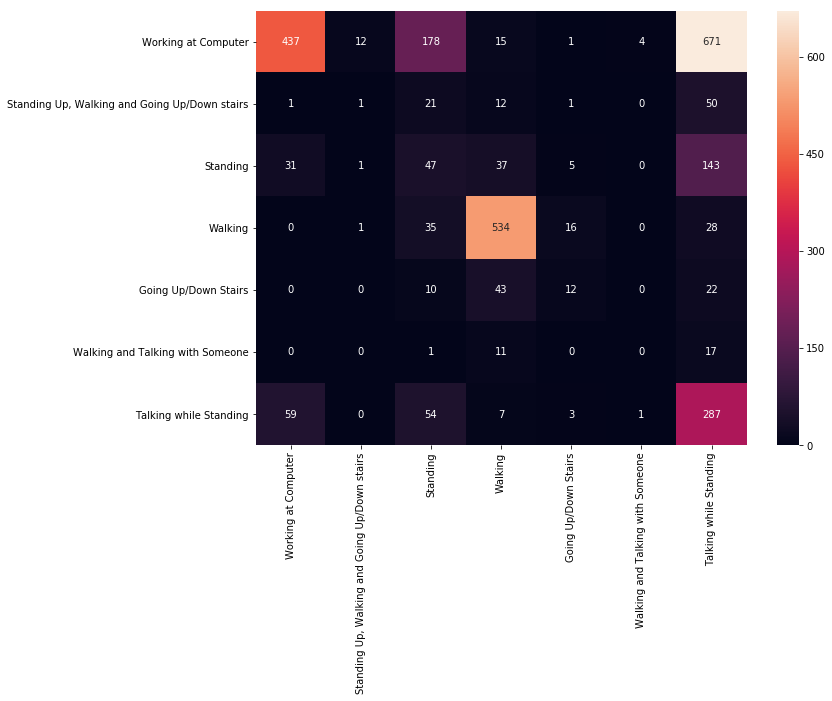

In [263]:
print("Validation set")#. Model Accuracy:",history_cnn.history['val_acc'][-1])
conf_mat = get_conf_matr(y_val,y_val_pred_cnn_argmax)
cnf_matrix_val = confusion_matrix(y_val, y_val_pred_cnn_argmax)
draw_conf_mat(cnf_matrix_val)
get_analytics(conf_mat)

Test set

Precision :

	 1 : 0.69 	 Working at Computer
	 2 : 0.03 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.06 	 Standing
	 4 : 0.78 	 Walking
	 5 : 0.33 	 Going Up/Down Stairs
	 6 : 0.01 	 Walking and Talking with Someone
	 7 : 0.32 	 Talking while Standing

Recall :

	 1 : 0.17 	 Working at Computer
	 2 : 0.02 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.12 	 Standing
	 4 : 0.87 	 Walking
	 5 : 0.10 	 Going Up/Down Stairs
	 6 : 0.02 	 Walking and Talking with Someone
	 7 : 0.68 	 Talking while Standing

F1 score :

	 1 : 0.27 	 Working at Computer
	 2 : 0.03 	 Standing Up, Walking and Going Up/Down stairs
	 3 : 0.08 	 Standing
	 4 : 0.82 	 Walking
	 5 : 0.15 	 Going Up/Down Stairs
	 6 : 0.01 	 Walking and Talking with Someone
	 7 : 0.43 	 Talking while Standing

Accuracy :	0.40


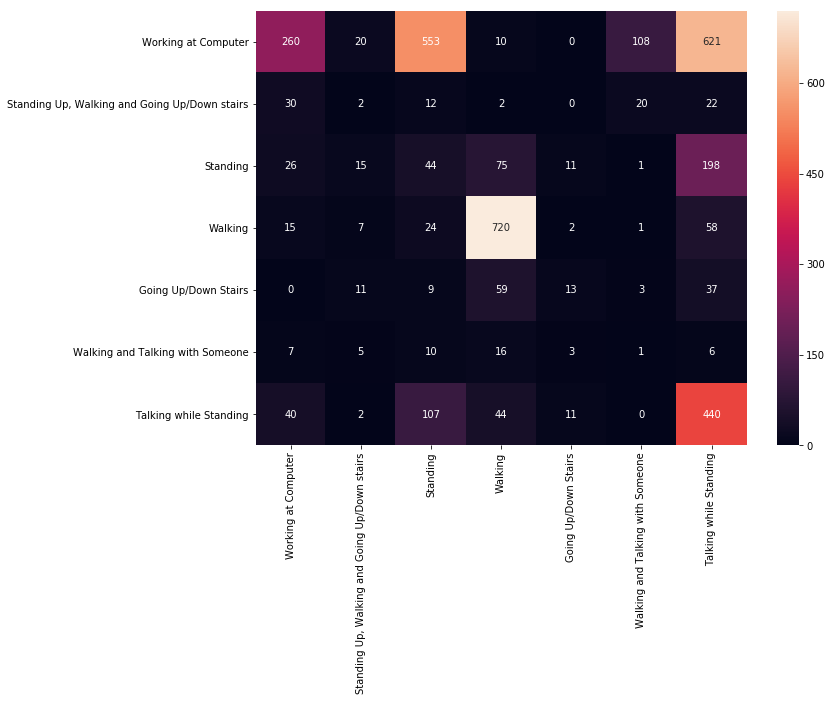

In [266]:
print("Test set")
conf_mat = get_conf_matr(y_test,y_test_pred_cnn_argmax)
get_analytics(conf_mat)
cnf_matrix_test = confusion_matrix(y_test, y_test_pred_cnn_argmax)
draw_conf_mat(cnf_matrix_test)
